<a href="https://colab.research.google.com/github/farkoo/GNN-Citations/blob/master/gnn_citations_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node Classification with Graph Neural Networks


## معرفی
<div dir=rtl>
در این پروژه یک مقایسه ی ساده بین معیارهای سنتی و روش های مبتنی بر شبکه‌های عصبی برای عمل node classification انجام شده است. دیتاستی که برای این کار استفاده 
شده است دیتاست cora است و عمل مورد نظر تخمین موضوع مقاله با استفاده از شبکه‌ی ارجاعات و کلمات استفاده شده در مقاله است. 
</div>


## Setup

In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn import metrics

## آماده سازی دیتاست

<div dir=rtl>
دیتاست cora شامل 2708 مقاله‌ی علمی است که در 7 کلاس دسته‌بندی شده اند. شبکه‌ی ارجاعات شامل 5429 لینک بین مقالات است. برای هر مقاله یک وکتور باینری به اندازه‌ی 1433 وجود دارد که هر درایه‌ی آن وجود یا عدم وجود یک کلمه را در متن نشان می‌دهد. 
</div>

### دانلود دیتاست

<div dir=rtl>
مجموعه داده دارای دو فایل جداگانه است: «cora.cites» و «cora.content».

1. «cora.cites» شامل رکوردهای ارجاع با دو ستون است:
مقاله‌ی ارجاع دهنده و مقاله‌ی ارجاع شده
2. «cora.content» شامل رکوردهای محتوی مقالات با 1435 ستون است: ID مقاله، موضوع و 1433 ویژگی باینری.

<div>

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

### پردازش و ترسیم دیتاست

<div dir=rtl>
در این قسمت شبکه‌ی ارجاعات درون یک DataFrame بارگذاری می‌شود.
<div>


In [ ]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


<div dir=rtl>
اکنون نمونه ای از ارجاعات DataFrame را نمایش می دهیم. ستون هدف شامل شناسه‌ی مقالاتی است که توسط مقاله‌هایی که شناسه‌ی آن‌ها در ستون منبع آمده است؛ به آن‌ها ارجاع داده شده است.
</div>

In [ ]:
citations.sample(frac=1).head()

,target,source
1833,12330,107569
4363,166989,25805
1011,4335,62417
2832,34257,34266
4793,307015,643199


<div dir=rtl>
در این قسمت اطلاعات مقالات درون یک DataFrame بارگذاری می‌شود.
<div>

In [ ]:
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", 
    names=["paper_id"] + [f"word_{i}" for i in range(1433)] + ["subject"],
)
print("Papers shape:", papers.shape)
papers = papers.sort_values(by = 'paper_id')

Papers shape: (2708, 1435)


<div dir=rtl>
اکنون نمونه ای از مقالات DataFrame را نمایش می دهیم. DataFrame شامل paper_id و ستون های موضوع، و همچنین 1433 ستون باینری است که نشان می دهد آیا کلمه ای در مقاله وجود دارد یا خیر.
</div>

In [ ]:
print(papers.sample(frac=1).head())

     paper_id  word_0  word_1  ...  word_1431  word_1432                subject
996   1131300       0       0  ...          0          0  Probabilistic_Methods
607    307336       0       0  ...          0          0        Neural_Networks
715   1105698       0       0  ...          0          0  Probabilistic_Methods
318      6767       0       0  ...          0          0             Case_Based
208     49660       0       0  ...          0          0                 Theory

[5 rows x 1435 columns]


<div dir=rtl>
در این قسمت تعداد مقالات هر موضوع مشخص شده و نمودار مربوط به آن رسم شده است.
</div>

In [ ]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

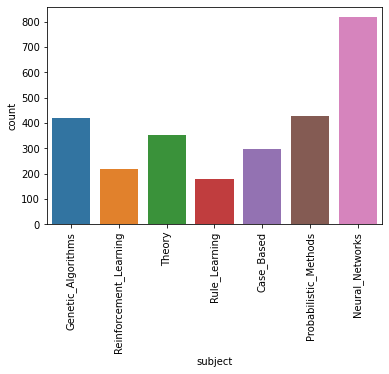

In [ ]:
sns.countplot(data=papers, x=papers.subject)
plt.xticks(rotation=90)

<div dir=rtl>
شناسه های مقالات و موضوعات را به عدد (با شروع از صفر) تبدیل می کنیم. بنابراین شناسه‌های مقالات اعدادی بین صفر تا 2707 و موضوعات اعدادی بین صفر تا 6 هستند.
</div>


In [ ]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

<div dir=rtl>
حالا نمودار ارجاعات را رسم می‌کنیم. هر گره در نمودار نشان دهنده یک مقاله است و رنگ گره با موضوع آن مطابقت دارد. باید توجه شود که ما فقط نمونه ای از مقالات موجود در مجموعه داده را نشان می دهیم.
</div>

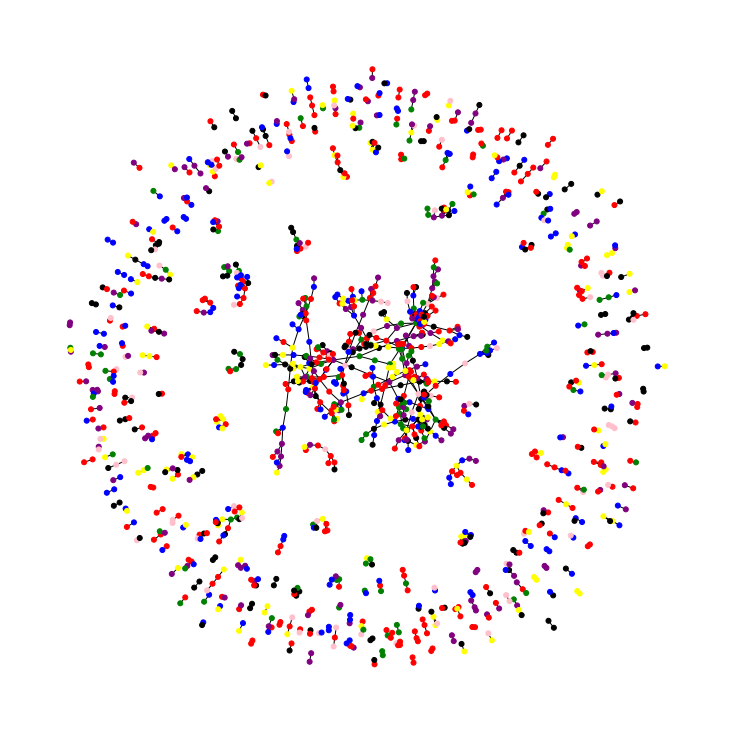

In [ ]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1000))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
val_map = {0: 'yellow', 
           1: 'blue',
           2: 'red',
           3: 'black',
           4: 'green',
           5: 'pink',
           6: 'purple'
          }

values = [val_map.get(s, 0.25) for s in subjects]
nx.draw(cora_graph, node_size=25, node_color=values)


###بخش اول: استخراج ویژگی‌های سنتی و آموزش مدل‌های یادگیری ماشین

*   List item
*   List item


<div dir=rtl>
مجموعه داده را به مجموعه های آموزش و تست تقسیم می‌کنیم.
</div>


In [ ]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.77
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (2092, 1435)
Test data shape: (616, 1435)


<div dir=rtl>
در این قسمت گراف جهت‌دار شبکه‌ی ارجاعات را تشکیل می‌دهیم تا با استفاده از آن ویژگی‌های سنتی را استخراج کنیم. در این گراف گره‌ها مقالات هستند و ارجاع بین آن‌ها با استفاده از یک یال جهت‌دار از مقاله‌ی ارجاع دهنده به مقاله‌ی ارجاع شده مشخص می‌شود.
</div>

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(np.unique(papers['paper_id']))
for i in range(citations.shape[0]):
  G.add_edge(citations.iloc[i]['source'], citations.iloc[i]['target'])

<div dir=rtl>
در این‌جا ویژگی‌های سنتی از گراف استخراج می‌شود و در یک ‌DataFrame به نام features ذخیره می‌شود. این ویژگی‌ها شامل موارد زیر هستند:
</div>
degree centrality <br>
in degree centrality <br>
out degree centrality <br>
average neighbor degree <br>
eigenvector centrality <br>
closseness centrality <br>
betweenness centrality <br>
load centrality <br>
harmonic centrality <br>
pagerank <br>
clustering <br>
subject <br>

In [ ]:
features = pd.DataFrame(columns={"node"})
# degree_centrality = nx.degree_centrality(G)
# features['node'] = degree_centrality.keys()
features['node'] = G.nodes()
features.insert(features.shape[1],"degree_centrality", nx.degree_centrality(G).values())
features.insert(features.shape[1],"in_degree_centrality", nx.in_degree_centrality(G).values())
features.insert(features.shape[1],"out_degree_centrality", nx.out_degree_centrality(G).values())
features.insert(features.shape[1],"average_neighbor_degree", nx.average_neighbor_degree(G).values())
features.insert(features.shape[1],"eigenvector_centrality", nx.eigenvector_centrality(G).values())
features.insert(features.shape[1],"closeness_centrality", nx.closeness_centrality(G).values())
# features.insert(features.shape[1],"current_flow_closeness_centrality", nx.current_flow_closeness_centrality(G).values())
features.insert(features.shape[1],"betweenness_centrality", nx.betweenness_centrality(G).values())
# features.insert(features.shape[1],"current_flow_betweenness_centrality", nx.current_flow_betweenness_centrality(G).values())
features.insert(features.shape[1],"load_centrality", nx.load_centrality(G).values())
features.insert(features.shape[1],"harmonic_centrality", nx.harmonic_centrality(G).values())
# features.insert(features.shape[1],"second_order_centrality", nx.second_order_centrality(G).values())
features.insert(features.shape[1],"pagerank", nx.pagerank(G, alpha = 0.8).values())
features.insert(features.shape[1],"clustering", nx.clustering(G).values())
features.insert(features.shape[1],"subject", papers['subject'].astype('int'))

<div dir=rtl>
پس از استخراج ویژگی‌های سنتی از گراف، با آموزش یک مدل random forest روی این ویژگی‌ها،  نود‌ها طبقه‌بندی ‌می‌شوند.
</div>

In [ ]:
X = features.to_numpy()[:, 1:12]
Y = features.to_numpy()[:, 12]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

model = RandomForestClassifier(max_depth=10, random_state=0)
model.fit(x_train, y_train)
y_pred=model.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.27740492170022374


<div dir=rtl>
در این قسمت علاوه بر ویژگی‌های سنتی از ویژگی‌های نود‌ها (بردار باینری نشان‌دهنده‌ی وجود یا عدم‌وجود کلمات) نیز برای آموزش مدل random forest استفاده می‌شود.
</div>

In [ ]:
X_all = pd.concat([features, papers], axis=1).drop(['paper_id', 'subject', 'node'], axis=1).to_numpy()
Y_all = features.to_numpy()[:, 12]
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(X_all, Y_all, test_size=0.33, random_state=42)

model = RandomForestClassifier(max_depth=10, random_state=0)
model.fit(x_train_all, y_train_all)
y_pred=model.predict(x_test_all)
print("Accuracy:",metrics.accuracy_score(y_test_all, y_pred))

Accuracy: 0.598434004474273


<div dir=rtl>
در این قسمت مراحل بالا برای آموزش یک مدل SVM تکرار می‌شود.
</div>

In [ ]:
model = SVC()
model.fit(x_train, y_train)
y_pred=model.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.31767337807606266


In [ ]:
model = SVC()
model.fit(x_train_all, y_train_all)
y_pred=model.predict(x_test_all)
print("Accuracy:",metrics.accuracy_score(y_test_all, y_pred))

Accuracy: 0.378076062639821


### <div dir="rtl">نتیجه گیری بخش اول:</div>

<div dir="rtl">
همانطور که در قسمتهای قبل مشاهده کردیم روش‌های گوناگونی برای دسته بندی نودها بکار بردیم و نتایج گوناگونی کسب کردیم. تفاوت این روش‌ها در مجموعه داده‌ی مورد استفاده برای آموزش مدل و دسته‌بندی داده های تست و انتخاب دسته‌بند مناسب بود.

در اولین روش از دسته‌بند جنگل تصادفی استفاده کردیم و برای آموزش مدل تنها از معیارهای سنتی که به ازای هر نود محاسبه شده بود بهره بردیم. صحت دسته بندی بر روی داده‌های تست با استفاده از این مدل برابر با ۲۷ درصد بود.

در دومین قسمت همانند قسمت قبلی از دسته‌بند جنگل تصادفی استفاده کردیم و از ترکیب ویژگیهای نودها و معیارهای سنتی برای آموزش مدل استفاده کردیم. نهایتا صحت ۵۹ درصد برای کلاسبندی داده‌های تست با استفاده از این مدل کسب شد.

در سومین روش تنها از معیارهای سنتی و دسته‌بند SVM استفاده کردیم و به صحت ۳۱ درصد برای دسته‌بندی داده‌های تست رسیدیم.

و در آخرین روش از ترکیب ویژگی‌های نودها و معیارهای سنتی برای آموزش مدل SVM مان استفاده کردیم و به صحت ۳۷ درصد برای دسته بندی داده های تست رسیدیم.

نتیجه گیری بخش اول: از روش‌های گوناگونی که در بخش اول استفاده کردیم نتیجه میگیریم که فارغ از قدرت دسته‌بندی که استفاده می‌کینم بکارگیری مجموعه ای از ویژگی‌های نودها و معیارهای سنتی نتیجه بهتری نسبت به تنها استفاده کردن از ویژگیهای نودها به ما می‌دهد چرا که معیارهای سنتی دربردارنده ی ویژگیهای ساختاری و ارتباطی شبکه گرافی هستند و در دسته‌بندی نودها کمک شایانی به ما می‌کنند.
<div>

##بخش دوم: پیاده‌ ‌سازی، آموزش و ارزیابی مدل‌های یادگیری عمیق

In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

<div dir=rtl>
این تابع با استفاده از داده های آموزشی داده شده یک مدل ورودی را کامپایل می‌کند و آموزش می دهد.
<div>

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


<div dir=rtl>
این تابع منحنی های loss و accuracy مدل را در طول آموزش نمایش می دهد.
</div>

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"], color = 'red')
    ax1.plot(history.history["val_loss"], color = 'black')
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"], color = 'red')
    ax2.plot(history.history["val_acc"], color = 'black')
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

##feedforward پیاده سازی ماژول شبکه‌ی 
<div dir=rtl>
ما از این ماژول در مدل های پایه و GNN استفاده خواهیم کرد.
</div>

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

##ساختن یک مدل شبکه عصبی پایه

### آماده سازی داده برای مدل پایه

<div dir=rtl>
در این قسمت داده‌های x_train, y_train, x_test, y_test برای آموزش مدل‌ها در مراحل بعدی آماده می‌شوند. داده‌های x شامل ویژگی‌های باینری گره‌ها و داده‌های y شامل موضوع گره‌ها (مقالات) هستند.
<div>


In [ ]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
X_train = train_data[feature_names].to_numpy()
X_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
Y_train = train_data["subject"]
هY_test = test_data["subject"]

### پیاده سازی یک مدل پایه

<div dir=rtl>
ما 9 بلوک FFN را با skip connection اضافه می کنیم، به طوری که یک مدل پایه با تقریباً همان تعداد پارامترهای مدل های GNN که بعدا ساخته می‌شود؛ ایجاد کنیم.
</dir>

In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(8):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")

### آموزش مدل پایه
<div dir=rtl>
برای آموزش مدل پایه در قسمت اول از ویژگی‌های سنتی استخراج شده در قسمت‌های قبل استفاده می‌کنیم.
<div>

In [ ]:
num_features = 11
baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()
history1 = run_experiment(baseline_model, x_train, y_train)

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 11)]         0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           1612        ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

<div dir=rtl>
منحنی‌های یادگیری مدل در زیر رسم شده است.
<div>

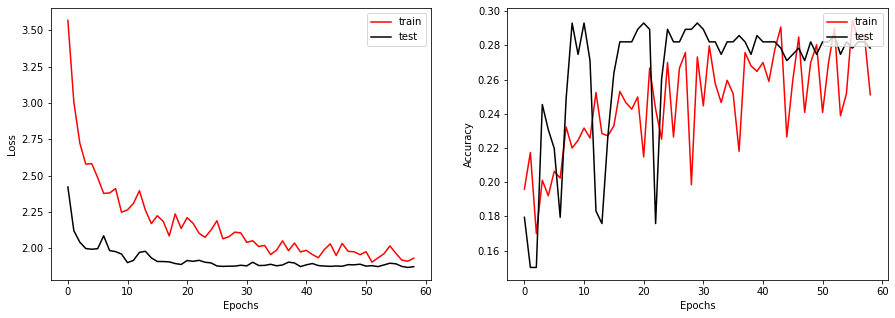

In [ ]:
display_learning_curves(history1)

<div dir=rtl>
 در اینجا دقت مدل آموزش داده شده محاسبه شده است.
<div>

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 30.65%


<div dir=rtl>
در قسمت دوم، مدل پایه با استفاده از ویژگی‌های باینری نود‌ها آموزش داده شده است. سپس مانند قسمت قبل منحنی‌ها رسم شده و دقت محاسبه شده است.
<div>

In [ ]:
num_features = 1433
baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()
history2 = run_experiment(baseline_model, X_train, Y_train)

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

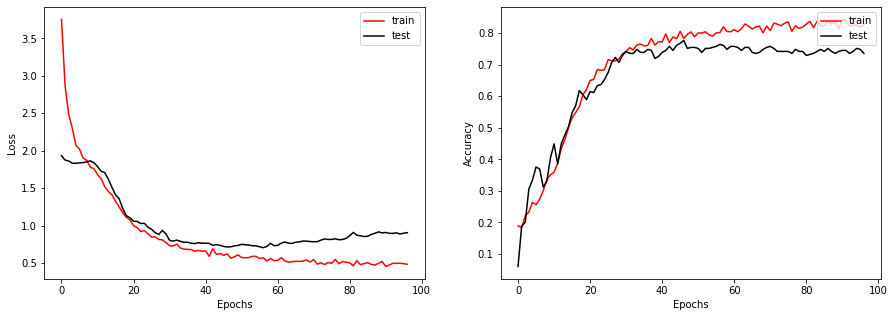

In [ ]:
display_learning_curves(history2)

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=X_test, y=Y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 78.57%


<div dir=rtl>
در نهایت مدل با استفاده از ترکیب ویژگی‌ها (سنتی و باینری) آموزش داده شده است و منحنی‌های مربوط به آن رسم و دقت محاسبه شده است.
<div>

In [ ]:
num_features = 1433 + 11
baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()
history3 = run_experiment(baseline_model, x_train_all, y_train_all)

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1444)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           53200       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

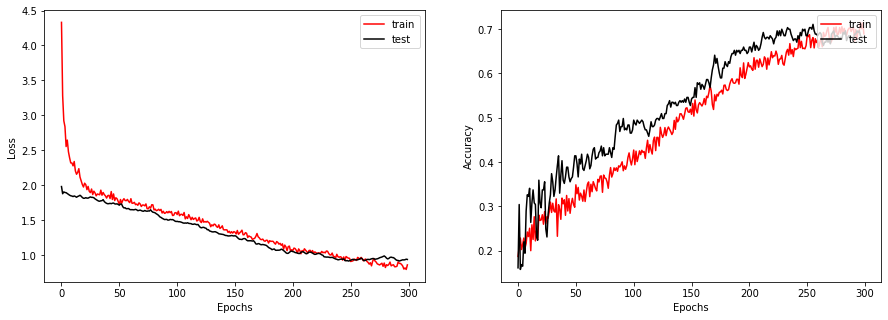

In [ ]:
display_learning_curves(history3)

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test_all, y=y_test_all, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 69.13%


### <div dir="rtl">نتیجه گیری بخش دوم:</div>

<div dir="rtl">
در این بخش از شبکه عصبی Feedforward برای آموزش مدلمان برای دسته‌بندی نودها استفاده کردیم. مشابه قسمت قبل در اینجا نیز با رویکردهای گوناگونی عملکرد شبکه‌مان رو با استفاده از داده‌های گوناگون بررسی کردیم که در زیر به اختصار در مورد آن توضیح می‌دهیم:

در روش اول از معیارهای سنتی که برای هر نود استخراج شده است برای آموزش شبکه‌ی FFN استفاده کردیم و نهایتا به صحت ۳۰ درصد رسیدیم.

در روش دوم تنها از ویژگی‌های باینری نودها استفاده کردیم و شبکه‌ی FFN را آموزش دادیم. در این قسمت پیشرفت چشمگیری داشتیم و توانستیم داد‌های تست را با صحت ۷۸ درصد کلاسبندی کنیم.

نهایتا در آخرین روش شبکه‌مان را با استفاده از ترکیبی از ویژگیهای باینری نودها و معیارهای سنتی آموزش دادیم و برخلاف قسمت با افت صحت در زمان دسته‌بندی داده‌های تست مواجه شدیم و به صحت ۶۹ درصد رسیدیم.
نتیجه میگیریم به دلیل تفاوت ماهیت داده‌های معیارهای سنتی و ویژگیهای باینری نودها عملکد شبکه افت کرده است.
<div>

##(GNN)بخش سوم: ساخت یک شبکه‌ی عصبی گراف 

### آماده سازی داده برای شبکه‌ی عصبی گراف

<div dir=rtl>
آماده‌سازی و بارگذاری داده‌های نمودارها در مدل برای آموزش، چالش‌برانگیزترین بخش در مدل‌های GNN است.
در این پروژه، ما یک رویکرد ساده برای تهیه و استفاده از داده‌های گراف را نشان می‌دهیم که اگر مجموعه داده از یک نمودار تشکیل شده باشد که به طور کامل در حافظه جا می‌گیرد، مناسب است.

داده های گراف با تاپل «graph_info» نشان داده می شود که از سه عنصر زیر تشکیل شده است:

1. "node_features": این یک آرایه NumPy با ابعاد [num_nodes, num_features] است که شامل ویژگی‌های گره است. در این مجموعه داده، گره ها مقالات هستند و ویژگی های_گره بردارهای باینری حضور کلمه هر مقاله هستند.
2. "edges": این یک آرایه NumPy با ابعاد [num_edges, num_edges] است که یک ماتریس مجاورت پراکنده از یال‌های بین گره‌ها را نشان می‌دهد. در این مثال، پیوندها، ارجاعات بین مقالات هستند.
3. "Edge_weights" (اختیاری):این یک آرایه NumPy با ابعاد "[num_edges]" است که شامل وزن‌های یال‌ها است و قدرت روابط بین گره‌ها را در نمودار مشخص می‌کند. در این مثال، وزنی برای ارجاعات مقاله وجود ندارد.
<div>


In [ ]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


### graph convolution layer پیاده سازی 

<div dir=rtl>
ما یک ماژول graph convolution را به عنوان لایه Keras پیاده سازی می کنیم
«GraphConvLayer» ما مراحل زیر را انجام می دهد:

1.  **Prepare** : نمایش گره ورودی (node representation) با استفاده از FFN برای تولید یک پیام پردازش می شود. این عمل میتواند با استفاده از توابع خطی نیز به سادگی انجام شود.
2. **Aggregate**: پیام های همسایگان هر گره با توجه به "edge_weights" با استفاده از یک عملیات permutaion invariant، مانند *جمع*، *میانگین*، و ...، تجمیع می شوند تا یک پیام برای هر گره ایجاد شود.
3. **Update**: representation هر گره و پیام‌‌ ‌‌‌‌‌‌‌ت‌‌ج‌م‌ی‌ع‌ ‌ش‌د‌ه‌‌‌ی‌ ‌آ‌ن‌ ‌ب‌ا‌ ‌ه‌‌م‌ ‌ت‌ر‌ک‌ی‌ب‌ ‌م‌ی‌‌‌ش‌و‌‌ن‌د‌ ‌و‌ ‌ی‌ک‌ ‌r‌e‌p‌r‌e‌s‌e‌n‌t‌a‌t‌i‌o‌n‌ ‌ج‌د‌ی‌د‌ ‌ب‌ر‌ا‌ی‌ ‌ه‌ر‌ ‌گ‌ر‌ه‌ ‌ا‌ی‌‌ج‌ا‌د‌ ‌م‌ی‌ش‌و‌د‌.‌
<div>


In [ ]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


### پیاده سازی یک شبکه‌ی عصبی گراف برای طبقه‌بندی نود‌ها

‌<div dir=rtl>
مدل GNN طبقه بندی نود‌ها به صورت زیر عمل می‌کند:
1. پیش پردازش با استفاده از FFN به ویژگی های گره اعمال می‌شود تا نمایش  اولیه‌ی گره ها ایجاد شود.
2. یک یا بیشتر لایه‌ی convolution با skip connection برای ایجاد node embedding به نمایش گره‌ها اعمال می‌شود.
3. پس پردازش با استفاده از FFN به embedding گره ها اعمال میشود تا node embedding های نهایی ایجاد شود.
4. برای تخمین کلاس گره یک لایه‌ی softmax روی embedding نهایی اعمال می‌شود.
<div>


In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create the third GraphConv layer.
        self.conv3 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv3",
        )
        # Create the forth GraphConv layer.
        self.conv4 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv4",
        )
        # Create the fifth GraphConv layer.
        self.conv5 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv5",
        )
        # Create the sixth GraphConv layer.
        self.conv6 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv6",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Apply the third graph conv layer.
        x3 = self.conv3((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x3 + x
        # Apply the forth graph conv layer.
        x4 = self.conv4((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x4 + x
        # Apply the fifth graph conv layer.
        x5 = self.conv5((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x5 + x
        # Apply the sixth graph conv layer.
        x6 = self.conv6((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x6 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


<div dir=rtl>
در این‌جا نمونه سازی و فراخوانی مدل GNN را آزمایش میکنیم.
</div>


In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.14861467 -0.09815494  0.05052063  0.0286662  -0.12208878 -0.16932918
   0.10487613]
 [ 0.04386604 -0.05445424  0.05483924 -0.09570114 -0.24510577 -0.06470599
   0.11537778]
 [-0.06569505  0.04367747  0.05626149 -0.05045615 -0.08924629 -0.03616297
   0.06142385]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                            

### GNN ‌آموزش مدل

<div dir=rtl>
برای آموزش مدل از standard supervised cross-entropy loss استفاده می کنیم. 
</div>

In [ ]:
X_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, X_train, Y_train)

Epoch 1/300
7/7 [==============================] - 14s 544ms/step - loss: 2.1641 - acc: 0.1991 - val_loss: 1.8826 - val_acc: 0.2962
Epoch 2/300
7/7 [==============================] - 2s 326ms/step - loss: 1.9627 - acc: 0.2655 - val_loss: 1.9048 - val_acc: 0.3025
Epoch 3/300
7/7 [==============================] - 2s 323ms/step - loss: 1.8824 - acc: 0.2750 - val_loss: 1.9186 - val_acc: 0.2229
Epoch 4/300
7/7 [==============================] - 2s 315ms/step - loss: 1.8850 - acc: 0.2756 - val_loss: 1.9028 - val_acc: 0.2962
Epoch 5/300
7/7 [==============================] - 2s 319ms/step - loss: 1.8550 - acc: 0.2942 - val_loss: 1.8877 - val_acc: 0.3217
Epoch 6/300
7/7 [==============================] - 2s 321ms/step - loss: 1.8415 - acc: 0.2936 - val_loss: 1.8662 - val_acc: 0.3057
Epoch 7/300
7/7 [==============================] - 2s 321ms/step - loss: 1.8299 - acc: 0.2964 - val_loss: 1.8547 - val_acc: 0.3121
Epoch 8/300
7/7 [==============================] - 2s 326ms/step - loss: 1.8036 - 

<div dir=rtl>
در نهایت نمودار‌های مربوط به مدل رسم می‌شود و دقت آن محاسبه می‌شود.
<div>

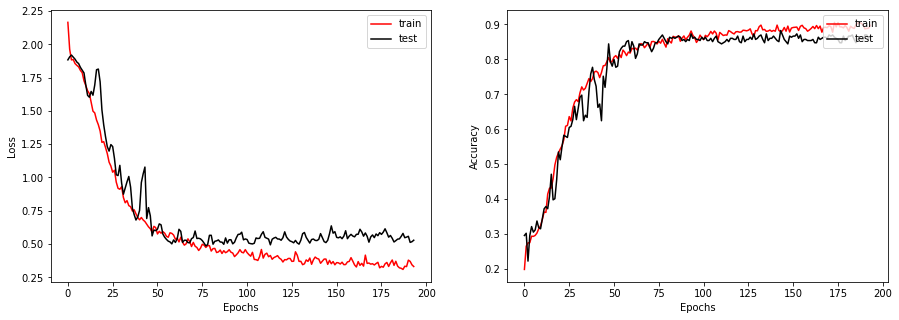

In [ ]:
display_learning_curves(history)

In [ ]:
X_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=X_test, y=Y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 88.15%


### <div dir="rtl">نتیجه گیری بخش سوم:</div>

<div dir="rtl">
در این قسمت از ساختار شبکه Graph Neural Network برای آموزش مدلمان بهره بردیم. از بخش دوم نتیجه گرفتیم که استفاده از ویژگیهای باینری نودها به تنهایی بهترین نتیجه را نسبت به دیگر روش‌ها برای ما به ارمغان می‌اورد و در این قسمت نیز تنها از ویژگیهای نودها برای آموزش مدل استفاده کردیم.

صحت دسته‌بندی نودها در داده‌های تست با استفاده از مدلی که به کمک GNN آموزش داده‌شده است برابر با ۸۸ درصد است که تفاوت قابل توجهی با بهترین صحت قسمتهای قبلی دارد، چرا که این شبکه بطور خاص برای کار با گراف‌ها و داده‌های ساختار یافته و شبکه ای طراحی شده است و ما این روش را به عنوان بهترین روش استفاده شده در این پروژه معرفی می‌کنیم.
<div>


### با تشکر از توجه شما